In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] a= 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False


# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

In [3]:
df = pd.read_csv('data/merged_data_brand_dropna.csv')

### 매출 급감/급증

In [10]:
# event_time 컬럼이 datetime 형식이어야 함
df['event_date'] = pd.to_datetime(df['event_time_moscow']).dt.date

# 매출(purchase만, price 합)
daily_revenue = df[df['event_type'] == 'purchase'].groupby('event_date')['price'].sum().reset_index()
daily_revenue.rename(columns={'price': 'daily_revenue'}, inplace=True)

# 전일 대비 변화율 계산
daily_revenue['pct_change'] = daily_revenue['daily_revenue'].pct_change() * 100

# 급변 조건 설정 (예: ±30% 이상 변화)
threshold = 50
revenue_spike = daily_revenue[abs(daily_revenue['pct_change']) >= threshold]
revenue_spike

,event_date,daily_revenue,pct_change
37,2019-11-07,48291.21,92.954057
39,2019-11-09,16739.76,-66.529263
41,2019-11-11,26540.56,50.010485
51,2019-11-21,46577.31,83.919972
55,2019-11-25,19386.20,-63.714710
58,2019-11-28,43666.83,83.045841
92,2020-01-01,8690.75,84.756659
93,2020-01-02,14127.28,62.555361
118,2020-01-27,52335.54,118.133826
120,2020-01-29,23007.87,-57.268207


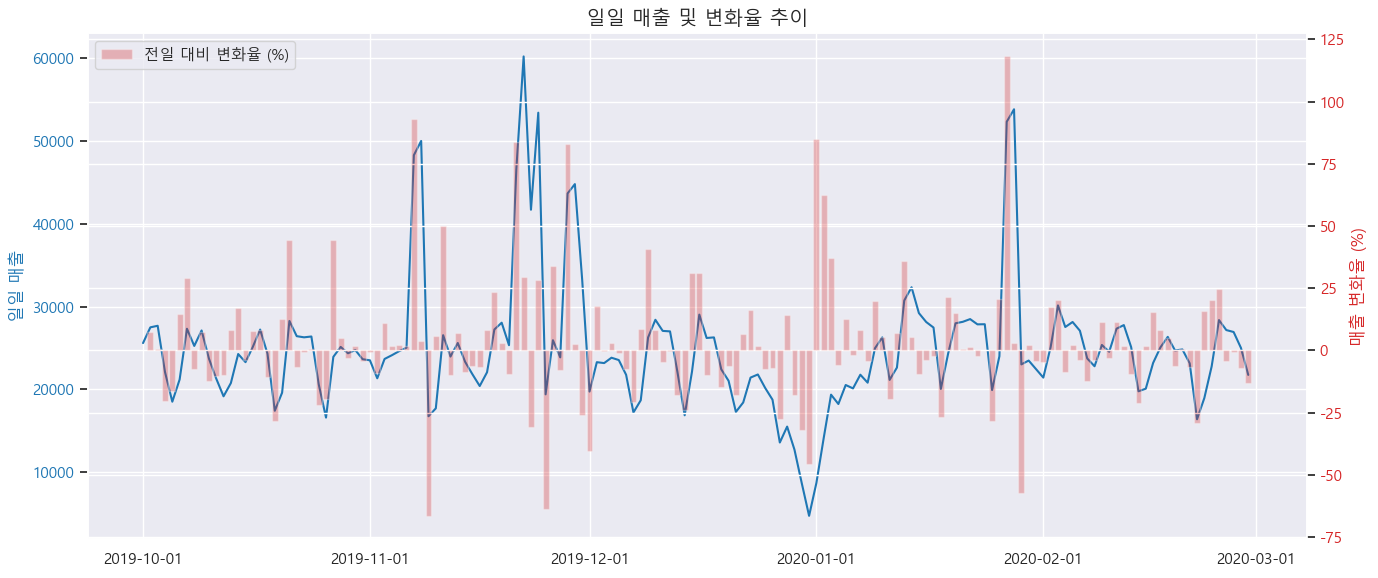

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(14, 6))

# x축 날짜 포맷팅
dates = pd.to_datetime(daily_revenue['event_date'])

# 왼쪽 y축: 매출 (Line)
ax1.plot(dates, daily_revenue['daily_revenue'], color='tab:blue', label='일일 매출')
ax1.set_ylabel('일일 매출', fontsize=12, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 오른쪽 y축: 변화율 (Bar)
ax2 = ax1.twinx()
ax2.bar(dates, daily_revenue['pct_change'], color='tab:red', alpha=0.3, label='전일 대비 변화율 (%)')
ax2.set_ylabel('매출 변화율 (%)', fontsize=12, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# 날짜 x축 형식 지정
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# 제목 및 범례
plt.title('일일 매출 및 변화율 추이', fontsize=14)
fig.tight_layout()
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


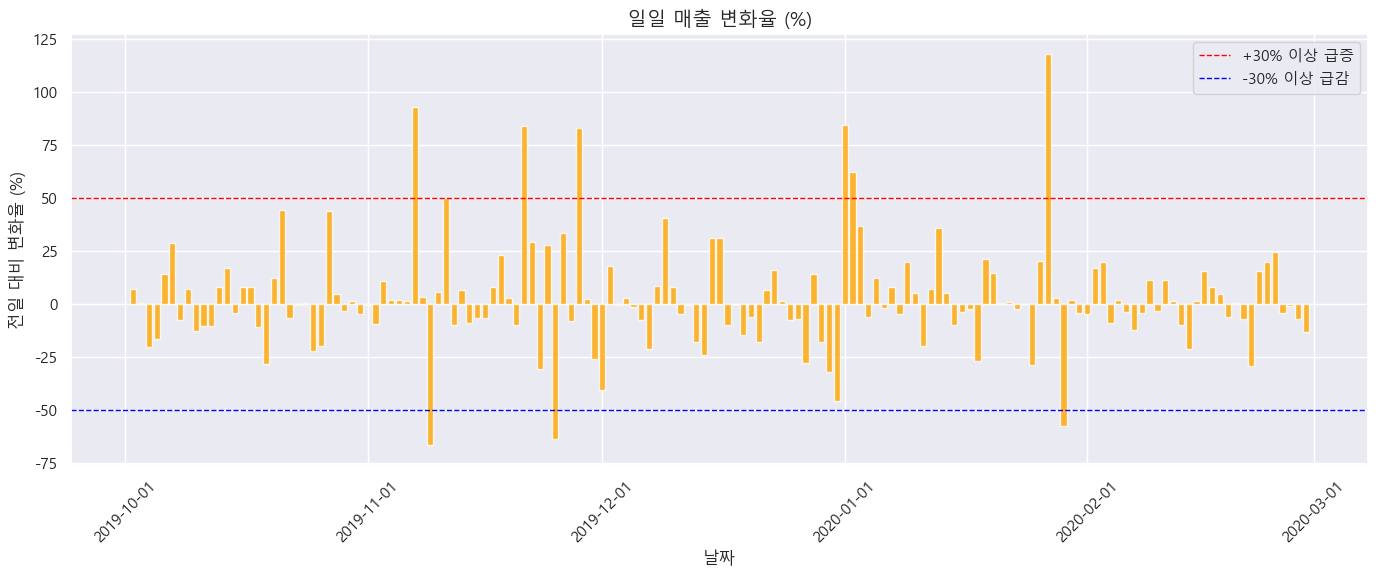

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 날짜를 datetime으로 변환 (시각화를 위해)
daily_revenue['event_date'] = pd.to_datetime(daily_revenue['event_date'])

plt.figure(figsize=(14, 6))
plt.bar(daily_revenue['event_date'], daily_revenue['pct_change'], color='orange', alpha=0.8)

# 축 및 제목 설정
plt.title('일일 매출 변화율 (%)', fontsize=14)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('전일 대비 변화율 (%)', fontsize=12)

# x축 날짜 포맷 설정
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# 기준선 (예: ±30%)
plt.axhline(y=50, color='red', linestyle='--', linewidth=1, label='+30% 이상 급증')
plt.axhline(y=-50, color='blue', linestyle='--', linewidth=1, label='-30% 이상 급감')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# 저장
revenue_spike.to_csv('data/08_revenue_spike_dates_50.csv', index=False)
print("✅ 매출 급감/급증 일자 저장 완료")

✅ 매출 급감/급증 일자 저장 완료


---
### 전환율

In [17]:
# 일별 view / purchase 수
daily_counts = df[df['event_type'].isin(['view', 'purchase'])].groupby(['event_date', 'event_type'])['user_id'].count().unstack(fill_value=0).reset_index()

# 전환율 계산
daily_counts['conversion_rate'] = daily_counts['purchase'] / daily_counts['view']
daily_counts['conversion_rate'] = daily_counts['conversion_rate'].replace([float('inf'), float('nan')], 0)

# 전일 대비 전환율 변화율
daily_counts['pct_change'] = daily_counts['conversion_rate'].pct_change() * 100

# 급변 조건 설정 (예: ±20% 이상)
threshold = 20
conversion_spike = daily_counts[abs(daily_counts['pct_change']) >= threshold]

# 저장
conversion_spike.to_csv('data/09_conversion_rate_spike_dates.csv', index=False)
print("✅ 전환율 급변 일자 저장 완료")

✅ 전환율 급변 일자 저장 완료


In [16]:
conversion_spike

event_type,event_date,purchase,view,conversion_rate,pct_change
2,2019-10-03,5492,35990,0.152598,27.459734
5,2019-10-06,4494,44816,0.100277,-24.088083
26,2019-10-27,4825,35411,0.136257,22.023870
37,2019-11-07,9151,44844,0.204063,54.848286
39,2019-11-09,3142,32102,0.097876,-55.804576
41,2019-11-11,4859,36920,0.131609,26.464277
51,2019-11-21,9279,51189,0.181269,35.242587
54,2019-11-24,12214,52692,0.231800,28.917333
55,2019-11-25,4134,42379,0.097548,-57.917015
56,2019-11-26,5176,40175,0.128836,32.074390


In [ ]:
import pandas as pd

# 1. 날짜 변환
df['event_time'] = pd.to_datetime(df['event_time_moscow'], errors='coerce')
df['event_date'] = df['event_time'].dt.date

# 2. 일별 view / purchase 수
daily_counts = (
    df[df['event_type'].isin(['view', 'purchase'])]
    .groupby(['event_date', 'event_type'])['user_id']
    .count()
    .unstack(fill_value=0)
    .reset_index()
)

# 3. 전환율 계산
daily_counts['conversion_rate'] = daily_counts['purchase'] / daily_counts['view']
daily_counts['conversion_rate'] = daily_counts['conversion_rate'].replace([float('inf'), float('nan')], 0)

# 4. 전일 대비 전환율 변화율
daily_counts['pct_change'] = daily_counts['conversion_rate'].pct_change() * 100

# 5. 월 정보 추가
daily_counts['event_month'] = pd.to_datetime(daily_counts['event_date']).to_period('M').astype(str)

# 6. ±20% 이상 변화한 날 필터링
threshold = 20
conversion_spike = daily_counts[abs(daily_counts['pct_change']) >= threshold]

# 7. 월별 급변 일자 수 집계
monthly_conversion_spike = (
    conversion_spike.groupby('event_month')
    .size()
    .reset_index(name='spike_day_count')
)

# 8. 결과 저장
monthly_conversion_spike.to_csv('data/09_monthly_conversion_spike_count.csv', index=False)
print("✅ 월별 전환율 급변 일자 수 저장 완료")